# 머신러닝 프로세스

1. 문제정의
2. 데이터수집
3. 데이터전처리
4. EDA(탐색적 데이터 분석)
5. 모델 선택 및 하이퍼파라미터 튜닝
6. 모델 학습
7. 모델 평가
8. 서비스화

#### 1. 문제정의

- 타이타닉 탑승객 정보를 학습해서 생존자, 사망자 분류(이진분류)
- 지도학습 방법 활용

#### 2. 데이터 수집
- kaggle 사이트에서 다운로드

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

#### 3. 데이터 전처리
- 결측치를 세밀하게 진행해보자
- binning(구간화) 작업을 해보자
- 비정형 데이터(Name)를 정형화 해보자
- 인코딩(one-hot-encoding)

##### Age 결측치 채우기
- 전체 데이터에 대한 기술통계가 아니라 세밀한 데이터 그룹 만들어서 결측치 채워보자

In [3]:
# Age 결측치 채우기   (corr: 상관계수 확인)
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [4]:
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

- Age와 반비례 관계가 컬럼 중 가장 강력한 것은 Pclass이다
- Age가 올라가면 Pclass는 떨어지는 관계

In [5]:
train['Age'].median() # 나이의 중앙값

28.0

In [6]:
train[['Age','Pclass']].groupby(by='Pclass').median()  # 등급별 나이의 중앙값 계산

,Age
Pclass,
1,37.0
2,29.0
3,24.0


In [7]:
age_tbl = train[['Age','Pclass','Sex']].groupby(by=['Pclass','Sex']).median() 
age_tbl

Age
Pclass Sex         
1      female  35.0
       male    40.0
2      female  28.0
       male    30.0
3      female  21.5
       male    25.0

In [8]:
age_tbl.loc[2]             #2등급인 사람만 구분

,Age
Sex,
female,28.0
male,30.0


In [9]:
age_tbl.loc[(2,'male')]    #튜플사용[()]: 2등급의 남성  #multi index색인방법

Age    30.0
Name: (2, male), dtype: float64

##### apply함수
- DataFrame이나 Series를 행 or 열 단위로 반복하면서 연산할때 사용하는 함수
- 복잡한 알고리즘을 만들어 적용할때 많이 사용 -> 함수로 작성

In [10]:
def fill_age(row):
    if np.isnan(row['Age']):     #결측치판별
        return age_tbl.loc[(row['Pclass'],row['Sex'])][0]  #값만 꺼내고 싶을때 Series의 0번째 값 채운다
    else: 
        return row['Age']

In [11]:
train['Age'] = train.apply(fill_age, axis=1)    # for대신에 apply함수 사용  #apply(행:axis=1, 열:axis=0)
test['Age'] = test.apply(fill_age, axis=1)

#### Fare, Embarked 결측치 채우기
- 결측치 수가 별로 없다, 전체 데이터의 기술 통계값으로 채우자
- 범주의 종류가 너무 많은 경우는 모델이 복잡해져 과대적합 우려가 있다.
- 범주의 종류를 단순화시켜보자

In [12]:
train['Embarked'].mode()[0]  # 최빈값 알려주는 함수 #[0]붙여서 index 제외하고 값만 추출

'S'

In [13]:
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

In [14]:
test['Fare'].fillna(train['Fare'].mean(), inplace=True)

In [15]:
# 결측치 확인
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

##### cabin결측치 처리하기
- 결측치를 하나의 데이터로 인정하고, 모델에 학습을 시켜볼 수도 있다.

In [16]:
train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [17]:
train['Cabin'].fillna('Missing', inplace=True)  # 결측치를 그냥 Missing으로 챙긴다
test['Cabin'].fillna('Missing', inplace=True)

In [18]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [19]:
train['Cabin'].unique()

array(['Missing', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62

In [20]:
train['Cabin'].str[0]   #문제열을 치환하여 [0]번껏만 출럭

0      M
1      C
2      M
3      C
4      M
      ..
886    M
887    B
888    M
889    C
890    M
Name: Cabin, Length: 891, dtype: object

In [21]:
train['Cabin'] = train['Cabin'].str[0]
train['Cabin'].unique()

array(['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [22]:
test['Cabin'] = test['Cabin'].str[0]

4. EDA(탐색적 데이터 분석)
 - SibSp, Parch 시각화

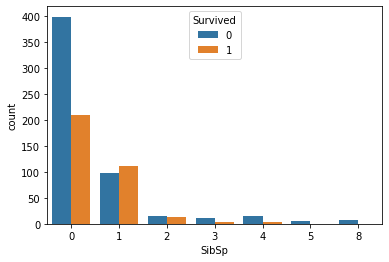

In [23]:
# 데이터의 개수(집계)를 세서 bar차트로 시각화

sns.countplot(data=train,
             x = 'SibSp',
             hue = 'Survived')

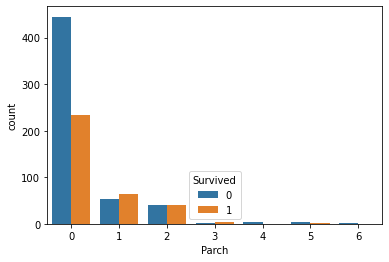

In [24]:
sns.countplot(data=train,
             x = 'Parch',
             hue = 'Survived')

In [25]:
# 특성공학:Feature에 여러가지 연산을 시켜 새로운 컬럼을 만들어 내는 것
train['Family'] = train['SibSp']+train['Parch']

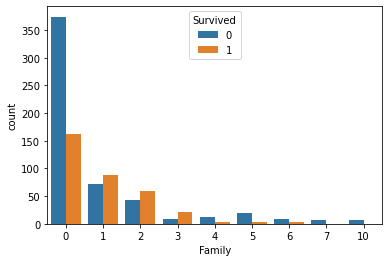

In [26]:
sns.countplot(data=train,
             x = 'Family',
             hue = 'Survived')

- 가족이 0명일때 죽을 확률이 높다
- 가족이 1~3명일 때 살 확률이 높다
- 가족이 4명 이상일 때 죽을 확률이 높다
- 가족은 수치형 데이터 타입이다.
- 구간화 작업을 통해 범주형 데이터로 만들고 모델에게 특성을 강조해보자

### binning(구간화)

In [27]:
data = train['Family']  #
bins = [-1, 0, 3, 20]    # 구간정보 0,1: 첫번째 구간의 시작점과 끝점, 1,4: 듀번째 구간의 시작점과 끝점...
categori = ['Alone','Small','Large']

train['Family_cat'] = pd.cut(data,
                          bins=bins,
                        labels=categori)

test['Family'] = test['SibSp']+test['Parch']
data = test['Family']
test['Family_cat'] = pd.cut(data,
                          bins=bins,
                        labels=categori)

In [28]:
train['Family_cat']

0      Small
1      Small
2      Alone
3      Small
4      Alone
       ...  
886    Alone
887    Alone
888    Small
889    Alone
890    Alone
Name: Family_cat, Length: 891, dtype: category
Categories (3, object): [Alone < Small < Large]

### 비정형데이터(Name)을 정형화
- 이름에서 호칭을 주자

In [29]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Family_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,M,S,1,Small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1,Small
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,M,S,0,Alone
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,1,Small
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,M,S,0,Alone


In [30]:
train['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [31]:
def split_title(name):
    return name.split(',')[1].split('.')[0].strip()
    #','을 중심으로 list형태로 변환[0, 1]  두번째인 1만 나오게
    # .split('.')[0]: .을 중심으로 list형태로 변환
    # strip() 문자열 제일 왼쪽이나 오른쪽에 있는 공백을 없애주는 기능

In [32]:
train['Title'] = train['Name'].apply(split_title)

In [33]:
test['Title'] = test['Name'].apply(split_title)

#### 인코딩(encoding)(문자타입->숫자타입)
- 원핫인코딩: 순서가 없는 범주형 데이터를 0과 1로 표현하는 방법

In [34]:
pd.get_dummies(train['Sex'])

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
...,...,...
886,0,1
887,1,0
888,1,0
889,0,1


In [35]:
pd.get_dummies(train['Embarked'])

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
886,0,0,1
887,0,0,1
888,0,0,1
889,1,0,0


In [36]:
pd.get_dummies(train['Cabin'], prefix="Cabin")

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,Cabin_T
0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
886,0,0,0,0,0,0,0,1,0
887,0,1,0,0,0,0,0,0,0
888,0,0,0,0,0,0,0,1,0
889,0,0,1,0,0,0,0,0,0


In [37]:
pd.get_dummies(train[['Cabin', 'Embarked']])

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,0,0,0,0,1,0,0,0,1
1,0,0,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,0,0,0,0,0,1,0,0,0,1
887,0,1,0,0,0,0,0,0,0,0,0,1
888,0,0,0,0,0,0,0,1,0,0,0,1
889,0,0,1,0,0,0,0,0,0,1,0,0


##### 문제와 답 분리

In [38]:
# 문제와 답 분리
X_train = train.drop('Survived' ,axis =1)
y_train = train['Survived']

In [39]:
X_train.shape, y_train.shape

((891, 14), (891,))

In [40]:
X_test = test

In [41]:
X_test.shape

(418, 14)

##### 사용하지 않을 컬럼 삭제

In [42]:
X_train.columns  ## PassengerId, Name, ticket 제외 

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Family', 'Family_cat', 'Title'],
      dtype='object')

In [43]:
X_train.drop(['PassengerId','Name','Ticket'], axis=1, inplace = True)

In [44]:
X_test.drop(['PassengerId','Name','Ticket'], axis=1, inplace = True)

##### train, test 원 핫 인코딩

In [45]:
categorical_features=['Sex','Cabin','Embarked','Family_cat','Title']

In [46]:
X_train_one_hot = pd.get_dummies(X_train[categorical_features])
X_train_one_hot

,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
887,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
888,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
889,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [47]:
X_train = pd.concat([X_train,X_train_one_hot], axis =1) # 이거를 여러번 실행시키셔서 그렇지 않았나 싶어요. 전체 다시 실행하니깐 괜찮아졌습니다. 감사합니다!!

In [48]:
X_train.drop(categorical_features, axis=1, inplace=True)

In [49]:
X_train.shape

(891, 40)

In [50]:
X_test_one_hot = pd.get_dummies(X_test[categorical_features])
X_test_one_hot

,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,...,Family_cat_Large,Title_Col,Title_Dona,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rev
0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
414,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
415,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
416,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [51]:
X_test = pd.concat([X_test,X_test_one_hot], axis =1)

In [52]:
X_test.drop(categorical_features, axis=1, inplace=True)

In [53]:
X_test.shape

(418, 31)

In [54]:
### 차이나는 컬럼 개수 확인
# 집합으로 공통분모 외에는 모두 제거
set(X_train.columns) - set(X_test.columns)

{'Cabin_T',
 'Title_Capt',
 'Title_Don',
 'Title_Jonkheer',
 'Title_Lady',
 'Title_Major',
 'Title_Mlle',
 'Title_Mme',
 'Title_Sir',
 'Title_the Countess'}

In [55]:
# 1. 컬럼 삭제

X_train.drop(['Cabin_T',
 'Title_Capt',
 'Title_Don',
 'Title_Jonkheer',
 'Title_Lady',
 'Title_Major',
 'Title_Mlle',
 'Title_Mme',
 'Title_Sir',
 'Title_the Countess'], axis=1, inplace=True)

In [56]:
# 집합으로 공통분모 외에는 모두 제거
set(X_test.columns) - set(X_train.columns)

#### 

{'Title_Dona'}

In [57]:
# 2. 컬럼추가
X_train['Title_Dona'] = 0
X_train

,Pclass,Age,SibSp,Parch,Fare,Family,Sex_female,Sex_male,Cabin_A,Cabin_B,...,Family_cat_Large,Title_Col,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Dona
0,3,22.0,1,0,7.2500,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,38.0,1,0,71.2833,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3,26.0,0,0,7.9250,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,35.0,1,0,53.1000,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
887,1,19.0,0,0,30.0000,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
888,3,21.5,1,2,23.4500,3,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
889,1,26.0,0,0,30.0000,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [58]:
X_train.shape, X_test.shape

((891, 31), (418, 31))

##### train에 Dona컬럼을 추가하면 데이터프레임의 맨 뒤에 추가된다. 컬럼의 순서가 변경됨

In [59]:
#컬럼 추가했지만, 컬럼의 위치가 다름
X_train.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family', 'Sex_female',
       'Sex_male', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_M', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Family_cat_Alone', 'Family_cat_Small',
       'Family_cat_Large', 'Title_Col', 'Title_Dr', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Ms', 'Title_Rev',
       'Title_Dona'],
      dtype='object')

In [60]:
X_test.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family', 'Sex_female',
       'Sex_male', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_M', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Family_cat_Alone', 'Family_cat_Small',
       'Family_cat_Large', 'Title_Col', 'Title_Dona', 'Title_Dr',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Ms',
       'Title_Rev'],
      dtype='object')

In [61]:
X_train.sort_index(axis = 1, inplace=True)

In [62]:
X_test.sort_index(axis = 1, inplace=True)

In [63]:
#컬럼 변경 후 위치 재확인
X_train.columns

Index(['Age', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_M', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Family', 'Family_cat_Alone', 'Family_cat_Large', 'Family_cat_Small',
       'Fare', 'Parch', 'Pclass', 'Sex_female', 'Sex_male', 'SibSp',
       'Title_Col', 'Title_Dona', 'Title_Dr', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Ms', 'Title_Rev'],
      dtype='object')

In [64]:
X_test.columns

Index(['Age', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_M', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Family', 'Family_cat_Alone', 'Family_cat_Large', 'Family_cat_Small',
       'Fare', 'Parch', 'Pclass', 'Sex_female', 'Sex_male', 'SibSp',
       'Title_Col', 'Title_Dona', 'Title_Dr', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Ms', 'Title_Rev'],
      dtype='object')

#### 5. 모델 선택 및 하이퍼파라미터 튜닝

In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [66]:
knn_model = KNeighborsClassifier(n_neighbors=4)     #이웃의 숫자
tree_model = DecisionTreeClassifier(random_state=215,
                                   max_depth=10)  #tree의 깊이

- 하이퍼파라미터 사용시, 과대·과소적합 판단을 위해 test데이터 적용시킴
- (그러나)현재 test 데이터는 정답이 없다.(Kaggle사이트가 가지고 있음)
- 하이퍼파라미터 튜닝을 위해 평가를 할수 있는 데이터셋을 만들어내자
- train 데이터를 train/validatin 데이터셋으로 쪼개서 사용해보자(7:3의 비율)

In [67]:
## 교차검증
from sklearn.model_selection import cross_val_score

In [68]:
knn_result = cross_val_score(knn_model, #교차검증을 돌릴 모델
                            X_train, #교차 검증에 사용할 데이터셋
                            y_train, #교차 검증에 사용할 데이터셋
                            cv = 9   # 교차검증 횟수
                            )

In [69]:
knn_result

array([0.70707071, 0.67676768, 0.72727273, 0.71717172, 0.6969697 ,
       0.68686869, 0.72727273, 0.72727273, 0.78787879])

In [70]:
knn_result.mean()

0.7171717171717171

##### knn튜닝

In [71]:
knn_train_list = [] # 훈련용 점수
knn_val_list = []  # 평가용 점수(validatin)

for k in range(1,100, 2):
    m = KNeighborsClassifier(n_neighbors=k)
    # 훈련용 데이터점수
    m.fit(X_train,y_train)
    train_scocre = m.score(X_train,y_train)
    knn_train_list.append(train_scocre)
    
    #검증용 데이터 점수
    knn_result = cross_val_score(m, X_train, y_train, cv=5)
    knn_val_list.append(knn_result.mean()) # 교차검증의 평균 값

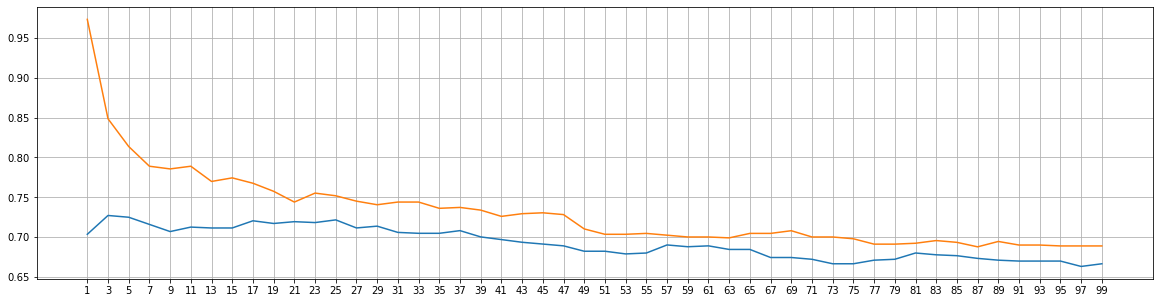

In [72]:
plt.figure(figsize=(20,5)) #가로,세로비율
plt.plot(range(1,100,2),
        knn_val_list)
plt.plot(range(1,100,2), # 훈련용 데이터 라인 그래프
        knn_train_list)
plt.xticks(range(1,100,2)) # X축 눈금조정
plt.grid() #배경에 격자무늬추가
plt.show()

### tree모델 튜닝

In [73]:
tree_train_list = [] # 훈련용 점수
tree_val_list = []  # 평가용 점수(validatin)

for depth in range(1,50):
    m = DecisionTreeClassifier(max_depth=depth, random_state=215)
    # 훈련용 데이터점수
    m.fit(X_train,y_train)
    train_scocre = m.score(X_train,y_train)
    tree_train_list.append(train_scocre)
    
    #검증용 데이터 점수
    tree_result = cross_val_score(m, X_train, y_train, cv=5)
    tree_val_list.append(tree_result.mean()) # 교차검증의 평균 값

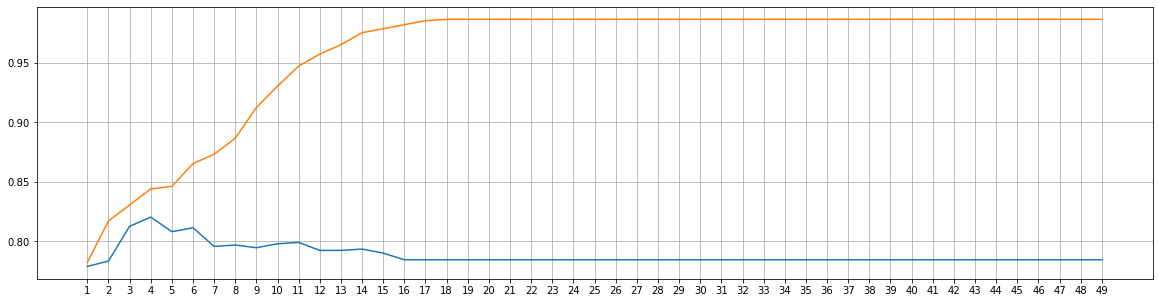

In [74]:
plt.figure(figsize=(20,5)) #가로,세로비율
plt.plot(range(1,50),
        tree_val_list)
plt.plot(range(1,50), # 훈련용 데이터 라인 그래프
        tree_train_list)
plt.xticks(range(1,50)) # X축 눈금조정
plt.grid() #배경에 격자무늬추가
plt.show()

#### 6.모델학습

In [75]:
final_knn_model = KNeighborsClassifier(n_neighbors=25)
final_tree_model = DecisionTreeClassifier(random_state=215,
                                         max_depth=4)

In [76]:
final_knn_model.fit(X_train, y_train)
final_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=215)

#### 7. 모델 평가

In [77]:
submission = pd.read_csv('data/gender_submission.csv')

In [78]:
knn_pre = final_knn_model.predict(X_test)  
submission['Survived'] = knn_pre     
submission.to_csv('knn_val_encoding.csv', index=False)

In [79]:
tree_pre = final_tree_model.predict(X_test)  

submission['Survived'] = tree_pre
submission.to_csv('tree_val_encoding.csv', index=False)

##### knn스케일링

In [80]:
from sklearn.preprocessing import RobustScaler

In [81]:
robust_scaler = RobustScaler()  #4분위수 이용한 스케일러

In [83]:
robust_scaler.fit(train[['Fare']])  # 스케일링을 위해서 해당데이터의 사분위수 측정

RobustScaler()

In [85]:
scaled_fare = robust_scaler.transform(train[['Fare']])   # 실제데이터로 변환
scaled_fare

array([[-3.12010602e-01],
       [ 2.46124229e+00],
       [-2.82776661e-01],
       [ 1.67373190e+00],
       [-2.77362969e-01],
       [-2.59679683e-01],
       [ 1.62013634e+00],
       [ 2.86743815e-01],
       [-1.43826658e-01],
       [ 6.76347793e-01],
       [ 9.72645693e-02],
       [ 5.23863558e-01],
       [-2.77362969e-01],
       [ 7.28501143e-01],
       [-2.85842977e-01],
       [ 6.69478900e-02],
       [ 6.35385628e-01],
       [-6.29807359e-02],
       [ 1.53566974e-01],
       [-3.13093341e-01],
       [ 5.00043310e-01],
       [-6.29807359e-02],
       [-2.78263807e-01],
       [ 9.11483958e-01],
       [ 2.86743815e-01],
       [ 7.33373467e-01],
       [-3.13093341e-01],
       [ 1.07644048e+01],
       [-2.84760238e-01],
       [-2.84041300e-01],
       [ 5.74570369e-01],
       [ 5.71974395e+00],
       [-2.90355831e-01],
       [-1.71254591e-01],
       [ 2.93277493e+00],
       [ 1.62609140e+00],
       [-3.12911441e-01],
       [-2.77362969e-01],
       [ 1.5

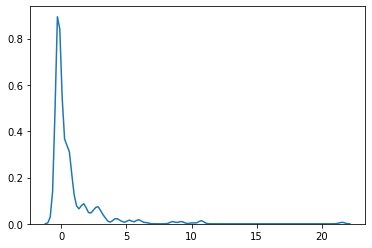

In [86]:
sns.kdeplot(scaled_fare.reshape(-1))   #원래 데이터는 0~500까지, 스케일링을 통해서 ~20까지 축소

In [87]:
# 스케일링된 요금을 이용해 KNN모델 학습
X_train_transform = X_train.copy()

In [88]:
X_train_transform['Fare'] = scaled_fare

In [91]:
X_test_transform = X_test.copy()

In [92]:
X_test_transform['Fare'] = robust_scaler.transform(X_test[['Fare']])

In [94]:
knn_model_scaled = KNeighborsClassifier(n_neighbors=25)
knn_model_scaled.fit(X_train_transform,y_train)

KNeighborsClassifier(n_neighbors=25)

In [96]:
knn_pre = knn_model_scaled.predict(X_test_transform)
submission['Survived'] = knn_pre
submission.to_csv('knn_scaled.csv', index=False)